# Design Fair Demo

Welcome to the Emotion Watchers design fair! Here, we'll take a look into the end-to-end process of testing the emotion detection model, from data collection to inference. 

<p align="center">
  <img src="../images/transparent_logo.png" width="80" height="80">
</p>


In [1]:
from IPython.display import Image
from pathlib import Path
import os

## Data Collection

If not already done, be sure to collect the facial expression videos and pupillometry data of the participant. 

In order for the data processing step to work with the given commands, ensure that:

<input type='checkbox' > The video is saved in `C:\Users\meria\Pictures\Camera Roll`  <br>
<input type='checkbox' > The video name follows the structure of `<partipant_id>_<emotion>.mp4` <br>
<input type='checkbox' > The pupillometry data should be saved in `C:\Users\meria\Documents\GazePoint\result` <br>
<input type='checkbox' > The pupillometry file should be named `<participant_id>_all_gaze.csv` <br>
<input type='checkbox' > The output_path (`\data`) should be cleared <br>

In [2]:
id = "dka"
emotion = "anger"

## Data Processing

Once the data has been collected, it must be processed. 

The facial video is converted to a sequence of images and cropped to include only the face. The face can be detected either using the [Haar Cascade model](https://www.datacamp.com/tutorial/face-detection-python-opencv) or a UI. These images are then classified by the emotion and resized to be interpreted by the model.

The pupillometry data is processed using MATLAB to remove outliers, such as blinking. Then the average of the left and right pupil dilations is outputted. Since the pupillometry data is discrete and has gaps after removing outliers, we created a continuous function from the data points using a [cubic spline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html) interpolation technique.

To process the data, run the command below:



In [3]:
!python ..\data_processing\data_processing\process_data.py "C:\Users\meria\Pictures\Camera Roll" ..\data C:\Users\meria\Documents\GazePoint\result -r


   > Filtering the raw data in 1 files...

      - File 1 (pupil_dka.mat) left eye:
          Range Filter: 83 samples removed.
          Dilation Speed Filter: 387 samples removed.
          Deviation Filter: 99 samples removed.

      - File 1 (pupil_dka.mat) right eye:
          Range Filter: 83 samples removed.
          Dilation Speed Filter: 350 samples removed.
          Deviation Filter: 81 samples removed.

   > Done

   > Interpolating and smooting the valid raw data subsets of 1 files...

      - File 1 (pupil_dka.mat):
          left eye done.
          right eye done.
          Mean pupil diameter done.

   > Done
----------------------------------------------------------------------------------------------------


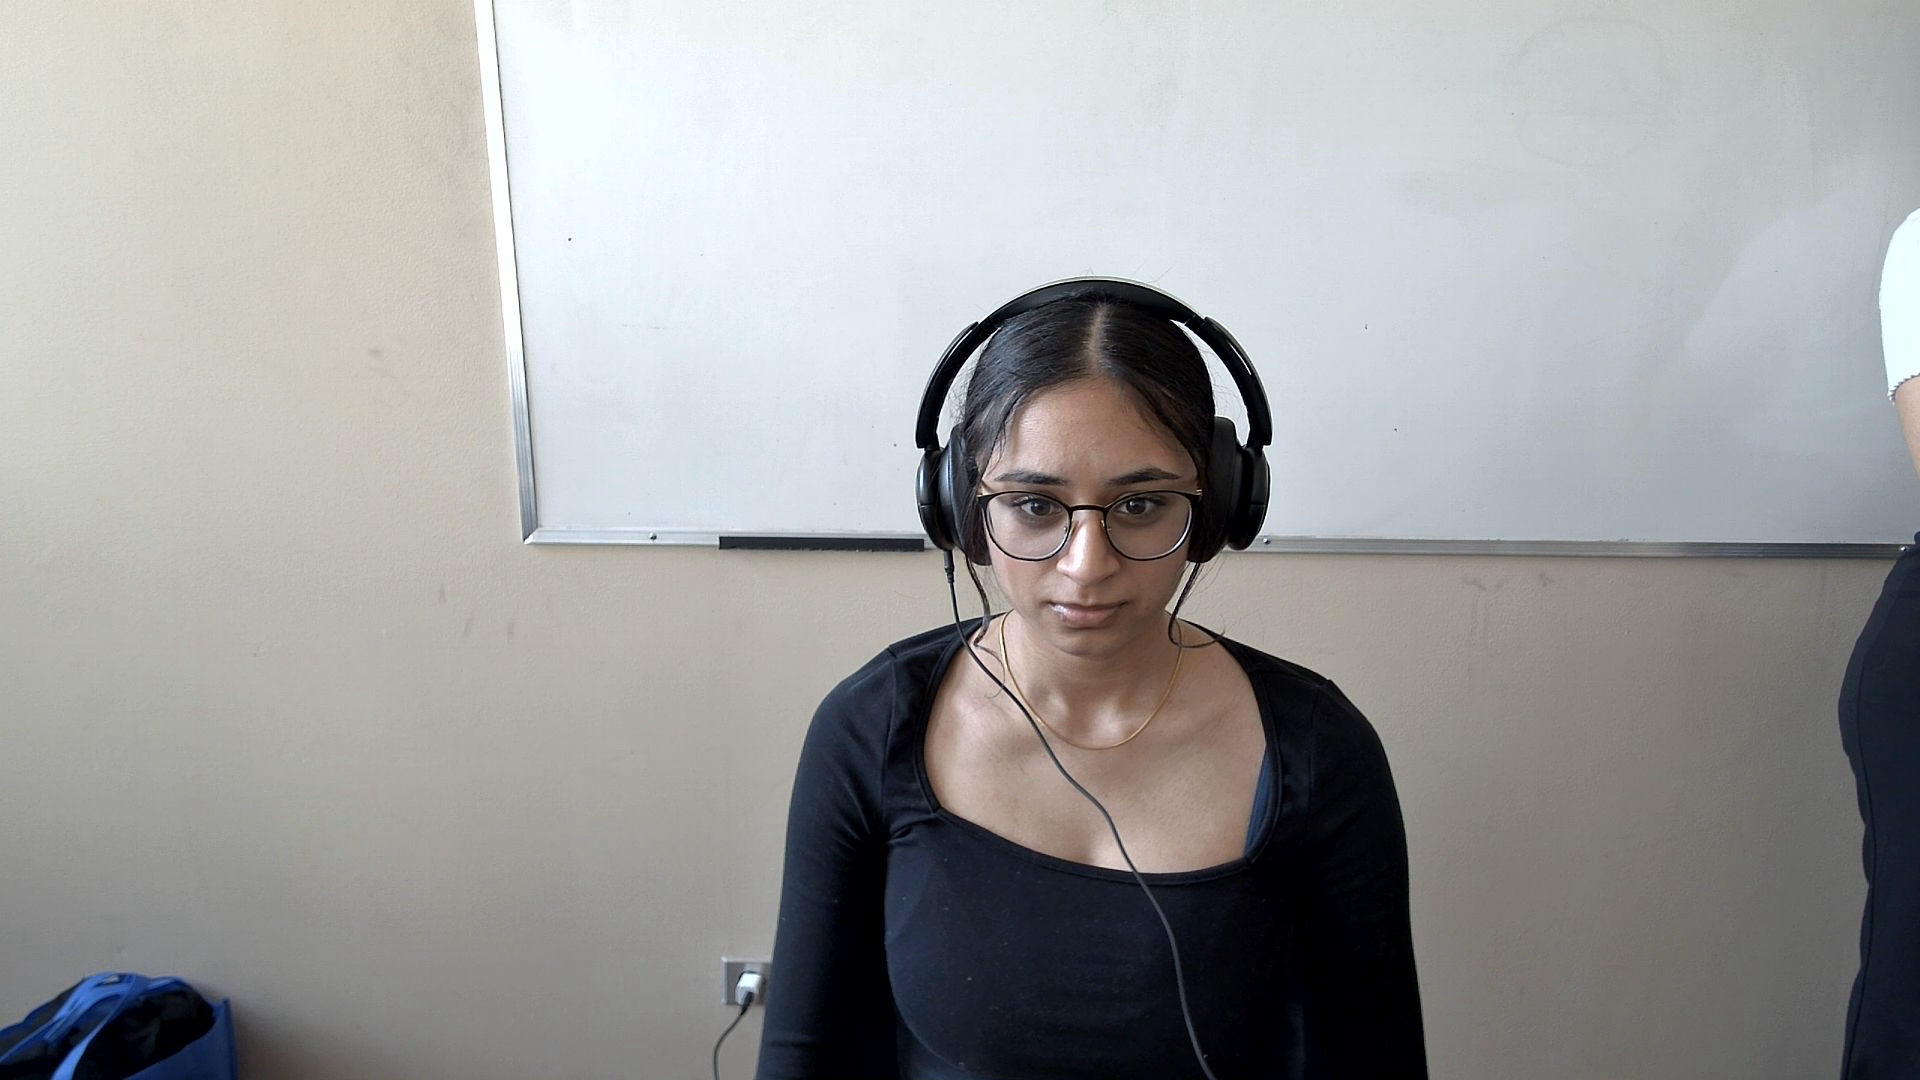

dka_anger_24.0.png


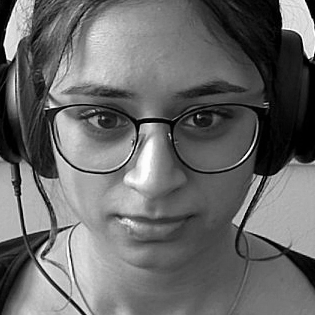

dka_anger_24.0_c.png


In [4]:
# Define the directory containing the frames
frame_dir = "C:\\Users\\meria\\Pictures\\Camera Roll"
frame_path = Path(frame_dir) / f"{id}_{emotion}"

# List all the frames in the directory
frames = os.listdir(frame_path)
mid = len(frames) // 2 
frame = frames[mid]  # Get the middle frame

# Display the middle frame
display(Image(frame_path / frame))
print(frame)

# Define the directory containing the cropped frames
cropped_dir = frame_path / "cropped"

# List all the cropped frames in the directory
cropped_frames = os.listdir(cropped_dir)
cropped_frame = cropped_frames[len(cropped_frames) // 2]  # Get the middle cropped frame

# Display the middle cropped frame
display(Image(cropped_dir / cropped_frame))
print(cropped_frame)


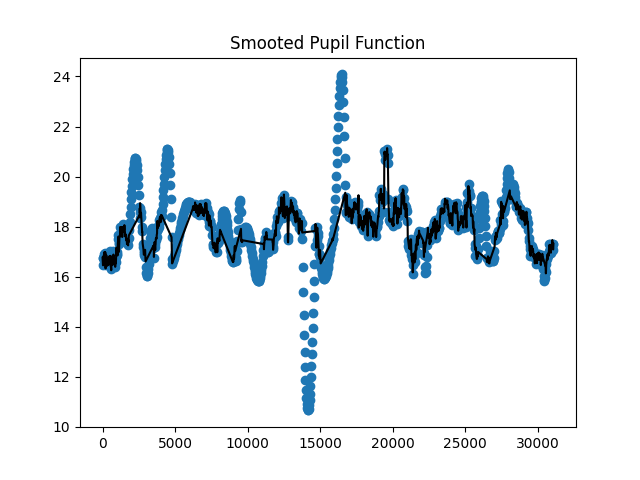

In [5]:
result_dir = Path("C:\\Users\\meria\\Documents\\GazePoint\\result")
plot_name = f"pupil_{id}_{emotion}.pkl.png"
display(Image(result_dir / plot_name))

## Models

To integrate facial expressions and pupillometry into emotion prediction, two separate models were initially developed and later combined into an ensemble. The facial model was trained on cropped and grayscale facial images, while the pupillometry model was trained on sequences of pupil dilations. The fusion model is utilized solely for testing purposes.

### Facial Model

The facial model processes cropped facial images and offers predictions in two modes: binary and multiclass.

- **Binary Mode**: Emotions are categorized as either positive or negative.
- **Multiclass Mode**: Emotions are classified into several categories, including anger, fear, joy, fun, calm, happy, and sad.

The current implementation utilizes the multiclass mode.

#### Architecture

The facial model employs the following architecture:

- **Convolutional Layers**: These layers are responsible for extracting features from the input images.
- **Linear Layers**: Following the feature extraction, linear layers make predictions based on the extracted features.


<p align="center">
  <img src="../images/face_model.png" height=200>
</p>
<p align="center">
  <i> Figure: Architecture of the Facial Model </i>
</p>

### Pupillometry Model

The pupillometry model focuses on binary classification at present. However, it can be extended to multiclass classification by incorporating binary predictions into corresponding emotions.

#### Classification Mode

- **Binary Classification**: The model currently operates in binary classification mode.

#### Architecture

The model prioritizes analyzing changes in pupil dilation rather than focusing solely on absolute dilation values. The architecture comprises:

- **LSTM Layers**: These layers retain memory over a sequence of dilations, capturing temporal dynamics.
- **Convolutional Layers**: Responsible for extracting features from pupil dilation sequences.
- **Linear Layers**: These layers make predictions based on the extracted features.

<p align="center">
  <img src="../images/pupil_model.png" height=200>
</p>
<p align="center">
  <i> Figure: Architecture of the Pupillometry Model </i>
</p>

### Fusion Model

The fusion model combines the predictions generated by the facial and pupillometry models and selects the emotion with the highest total confidence. This integration allows for a comprehensive assessment by leveraging insights from both modalities.

The fusion model's classification mode, whether binary or multiclass, is determined by the combined outputs of the facial and pupillometry models. If both models operate in binary mode, the fusion model will also produce binary predictions. Conversely, if either or both models utilize multiclass classification, the fusion model will follow suit.

By synthesizing information from both facial expressions and pupillometry, the fusion model provides a more robust and nuanced approach to emotion prediction.

In [6]:
!python ..\models\models\fusion.py C:\Users\meria\Documents\GazePoint\result ..\data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 1)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                   

2024-04-09 11:45:12.999590: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

2024-04-09 11:45:28.101212: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


dka_anger_25.0_c.png


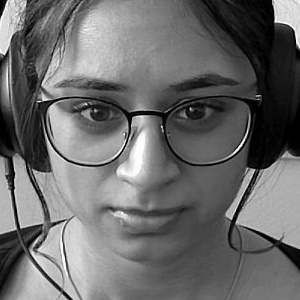

In [7]:
data_dir = "..\data"
frame_path = Path(data_dir) / f"{emotion}"
frames = os.listdir(frame_path)
mid = len(frames) // 2
frame = frames[mid]
print(frame)
Image(frame_path / frame)

#TODO: add code to output what emotion was predicted for this image

## Verification

In order to gain insight on the model's predictions, we generate a **confusion matrix**, seen below.



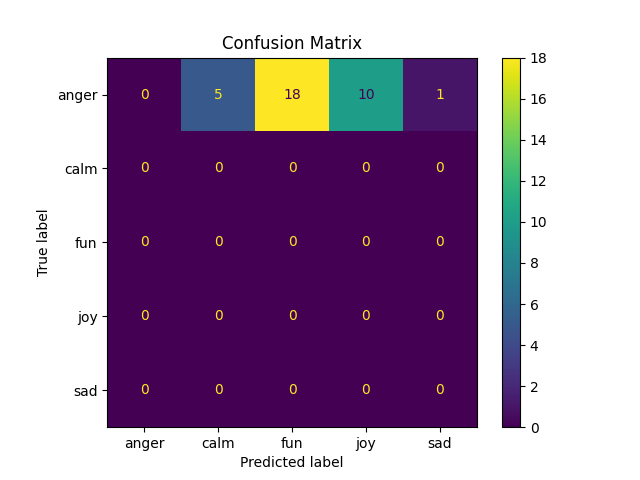

In [8]:
display(Image("..\models\models\confusion_matrix.png"))